### Data and dependencies setup


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING logs

In [3]:
import tensorflow as tf

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Restrict TensorFlow to only use one GPU (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Rest of your model code


2024-12-28 15:07:46.661139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735416469.136813     437 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735416469.584718     437 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1


In [8]:
%%capture
!pip install seaborn

In [7]:
%%capture
!pip install kaggle

In [10]:
%%capture
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

In [4]:
def get_class_paths(path):
  classes = []
  class_paths = []
  # Iterate through directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)# Check if it's a directory
    if os.path.isdir(label_path):# Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path,image)# Add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)
    # Create a DataFrame with the collected data
    df = pd.DataFrame({
    'Class Path': class_paths,
    'Class': classes
    })
  return df

In [5]:
tr_df = get_class_paths("./Training")

In [6]:
tr_df

,Class Path,Class
0,./Training/glioma/Tr-glTr_0000.jpg,glioma
1,./Training/glioma/Tr-glTr_0001.jpg,glioma
2,./Training/glioma/Tr-glTr_0002.jpg,glioma
3,./Training/glioma/Tr-glTr_0003.jpg,glioma
4,./Training/glioma/Tr-glTr_0004.jpg,glioma
...,...,...
5707,./Training/pituitary/Tr-pi_1452.jpg,pituitary
5708,./Training/pituitary/Tr-pi_1453.jpg,pituitary
5709,./Training/pituitary/Tr-pi_1454.jpg,pituitary
5710,./Training/pituitary/Tr-pi_1455.jpg,pituitary


In [7]:
ts_df = get_class_paths("./Testing")

In [8]:
ts_df

,Class Path,Class
0,./Testing/glioma/Te-glTr_0000.jpg,glioma
1,./Testing/glioma/Te-glTr_0001.jpg,glioma
2,./Testing/glioma/Te-glTr_0002.jpg,glioma
3,./Testing/glioma/Te-glTr_0003.jpg,glioma
4,./Testing/glioma/Te-glTr_0004.jpg,glioma
...,...,...
1306,./Testing/pituitary/Te-pi_0295.jpg,pituitary
1307,./Testing/pituitary/Te-pi_0296.jpg,pituitary
1308,./Testing/pituitary/Te-pi_0297.jpg,pituitary
1309,./Testing/pituitary/Te-pi_0298.jpg,pituitary


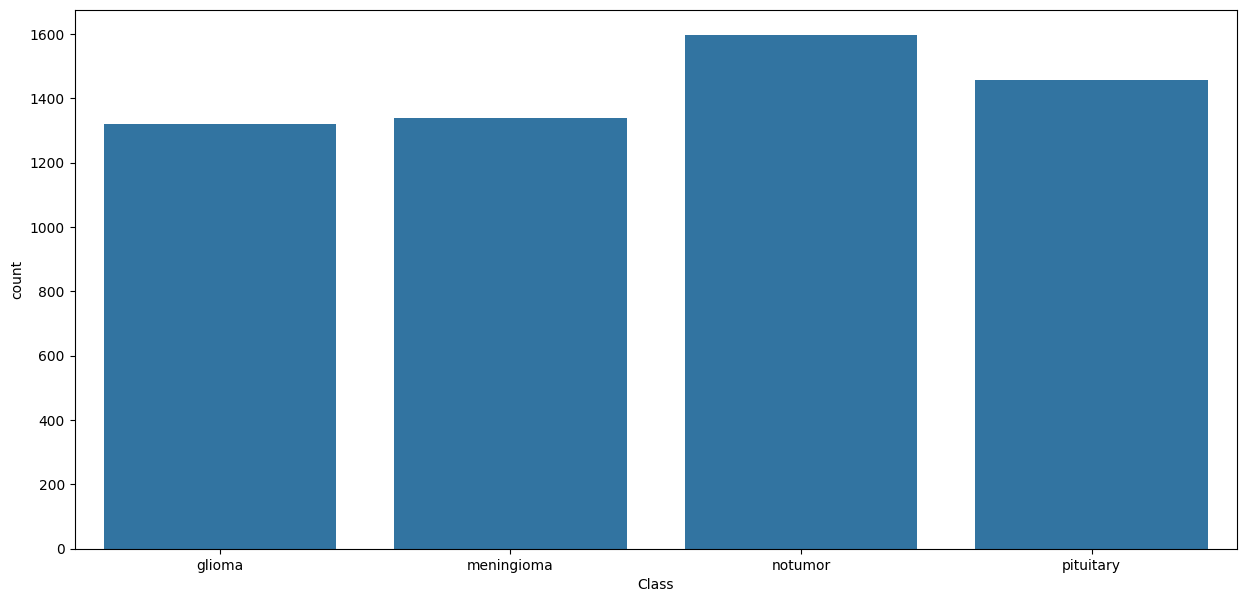

In [9]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data = tr_df, x=tr_df['Class'])

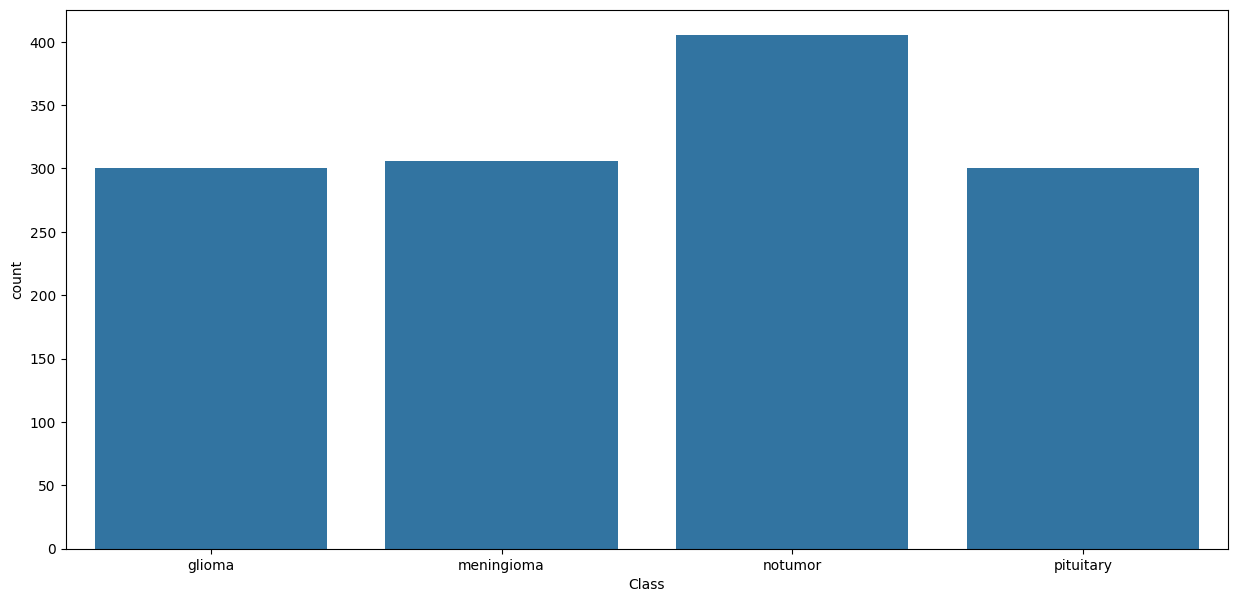

In [10]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data = ts_df, x=ts_df['Class'])

In [11]:
%%capture
pip install scikit-learn tensorflow matplotlib

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, stratify=ts_df['Class'])

In [13]:
valid_df

,Class Path,Class
77,./Testing/glioma/Te-gl_0077.jpg,glioma
234,./Testing/glioma/Te-gl_0234.jpg,glioma
714,./Testing/notumor/Te-no_0108.jpg,notumor
941,./Testing/notumor/Te-no_0335.jpg,notumor
1260,./Testing/pituitary/Te-pi_0249.jpg,pituitary
...,...,...
310,./Testing/meningioma/Te-me_0010.jpg,meningioma
1057,./Testing/pituitary/Te-pi_0046.jpg,pituitary
602,./Testing/meningioma/Te-me_0302.jpg,meningioma
376,./Testing/meningioma/Te-me_0076.jpg,meningioma


In [14]:
ts_df

,Class Path,Class
918,./Testing/notumor/Te-no_0312.jpg,notumor
619,./Testing/notumor/Te-no_0013.jpg,notumor
1106,./Testing/pituitary/Te-pi_0095.jpg,pituitary
835,./Testing/notumor/Te-no_0229.jpg,notumor
1009,./Testing/notumor/Te-no_0403.jpg,notumor
...,...,...
627,./Testing/notumor/Te-no_0021.jpg,notumor
275,./Testing/glioma/Te-gl_0275.jpg,glioma
896,./Testing/notumor/Te-no_0290.jpg,notumor
1282,./Testing/pituitary/Te-pi_0271.jpg,pituitary


### Preprocessing of the data

In [15]:
batch_size = 5

img_size = (128, 128)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [16]:
tr_gen = image_generator.flow_from_dataframe(tr_df, x_col = 'Class Path', y_col ='Class', batch_size=batch_size, target_size=img_size)

Found 5712 validated image filenames belonging to 4 classes.


In [17]:
valid_gen = image_generator.flow_from_dataframe(valid_df, x_col = 'Class Path', y_col ='Class', batch_size=batch_size, target_size=img_size)

Found 655 validated image filenames belonging to 4 classes.


In [18]:
ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col = 'Class Path', y_col ='Class', batch_size=5, target_size=img_size, shuffle=False)

Found 656 validated image filenames belonging to 4 classes.


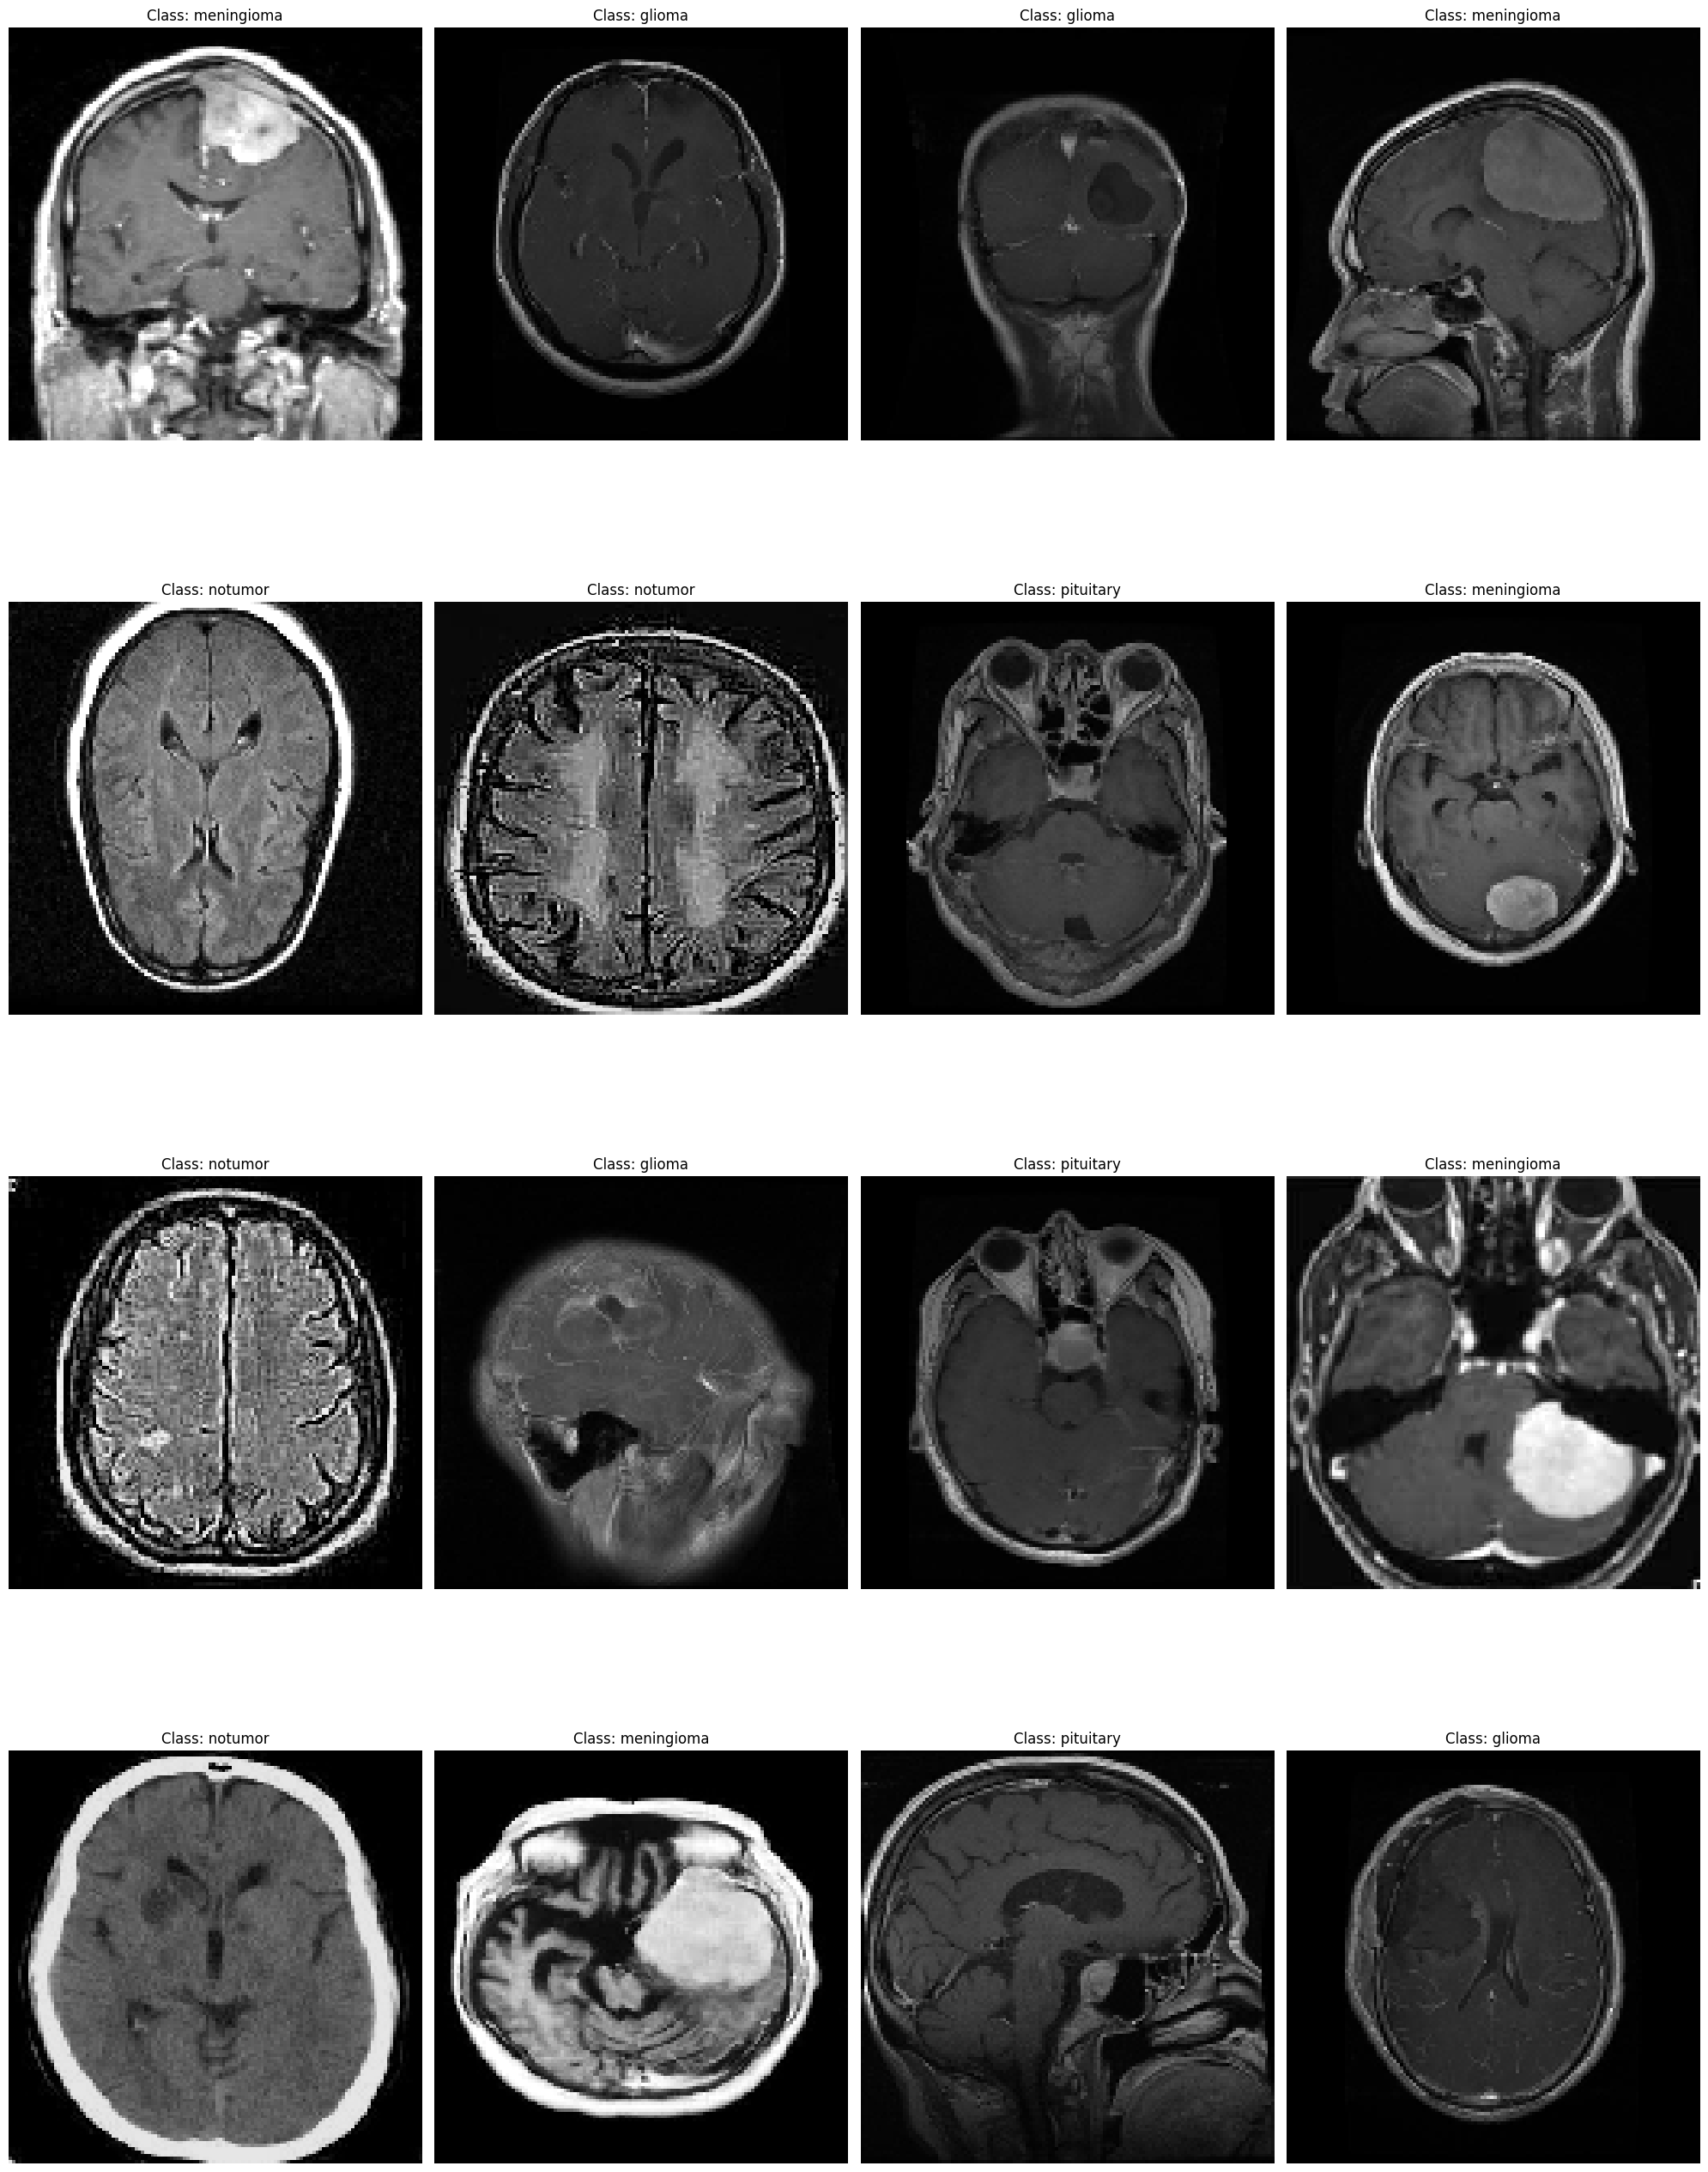

In [19]:
plt.figure(figsize=(20, 28))
for i in range (16):
  plt.subplot(4, 4, i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)
  class_index = np.argmax(label)
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())
  index_position = class_indices.index(class_index)
  class_name = class_names [index_position]
  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout ()
plt.show()

In [20]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [21]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
print("tf version",tf.__version__)
print("CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])

tf version 2.18.0
CUDA version: 12.5.1
cuDNN version: 9


In [22]:
from threading import active_count

In [23]:
img_shape=(128, 128,3)

base_model = tf.keras.applications.Xception(include_top=False,
                                           weights="imagenet",
                                           input_shape=img_shape,
                                           pooling='max')
model= Sequential([base_model,
                   Flatten(),
                   Dropout(rate=0.3),
                  Dense(128, activation='relu'),
                  Dropout(rate=0.25),
                   Dense(4, activation='softmax')
                   ])

InternalError: cudaSetDevice() on GPU:0 failed. Status: CUDA-capable device(s) is/are busy or unavailable

In [ ]:
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                      Precision(),
                      Recall()])

In [24]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/6
714/714 [==============================] - 232s 192ms/step - loss: 0.4700 - accuracy: 0.8314 - precision: 0.8880 - recall: 0.7759 - val_loss: 0.9029 - val_accuracy: 0.9099 - val_precision: 0.9300 - val_recall: 0.8931
Epoch 2/6
714/714 [==============================] - 74s 104ms/step - loss: 0.1670 - accuracy: 0.9447 - precision: 0.9520 - recall: 0.9379 - val_loss: 0.8614 - val_accuracy: 0.9588 - val_precision: 0.9646 - val_recall: 0.9573
Epoch 3/6
714/714 [==============================] - 66s 92ms/step - loss: 0.1018 - accuracy: 0.9685 - precision: 0.9730 - recall: 0.9652 - val_loss: 0.5146 - val_accuracy: 0.9679 - val_precision: 0.9753 - val_recall: 0.9649
Epoch 4/6
714/714 [==============================] - 64s 89ms/step - loss: 0.0589 - accuracy: 0.9818 - precision: 0.9835 - recall: 0.9806 - val_loss: 0.5523 - val_accuracy: 0.9802 - val_precision: 0.9816 - val_recall: 0.9786
Epoch 5/6
714/714 [==============================] - 64s 89ms/step - loss: 0.0426 - accuracy: 0.9

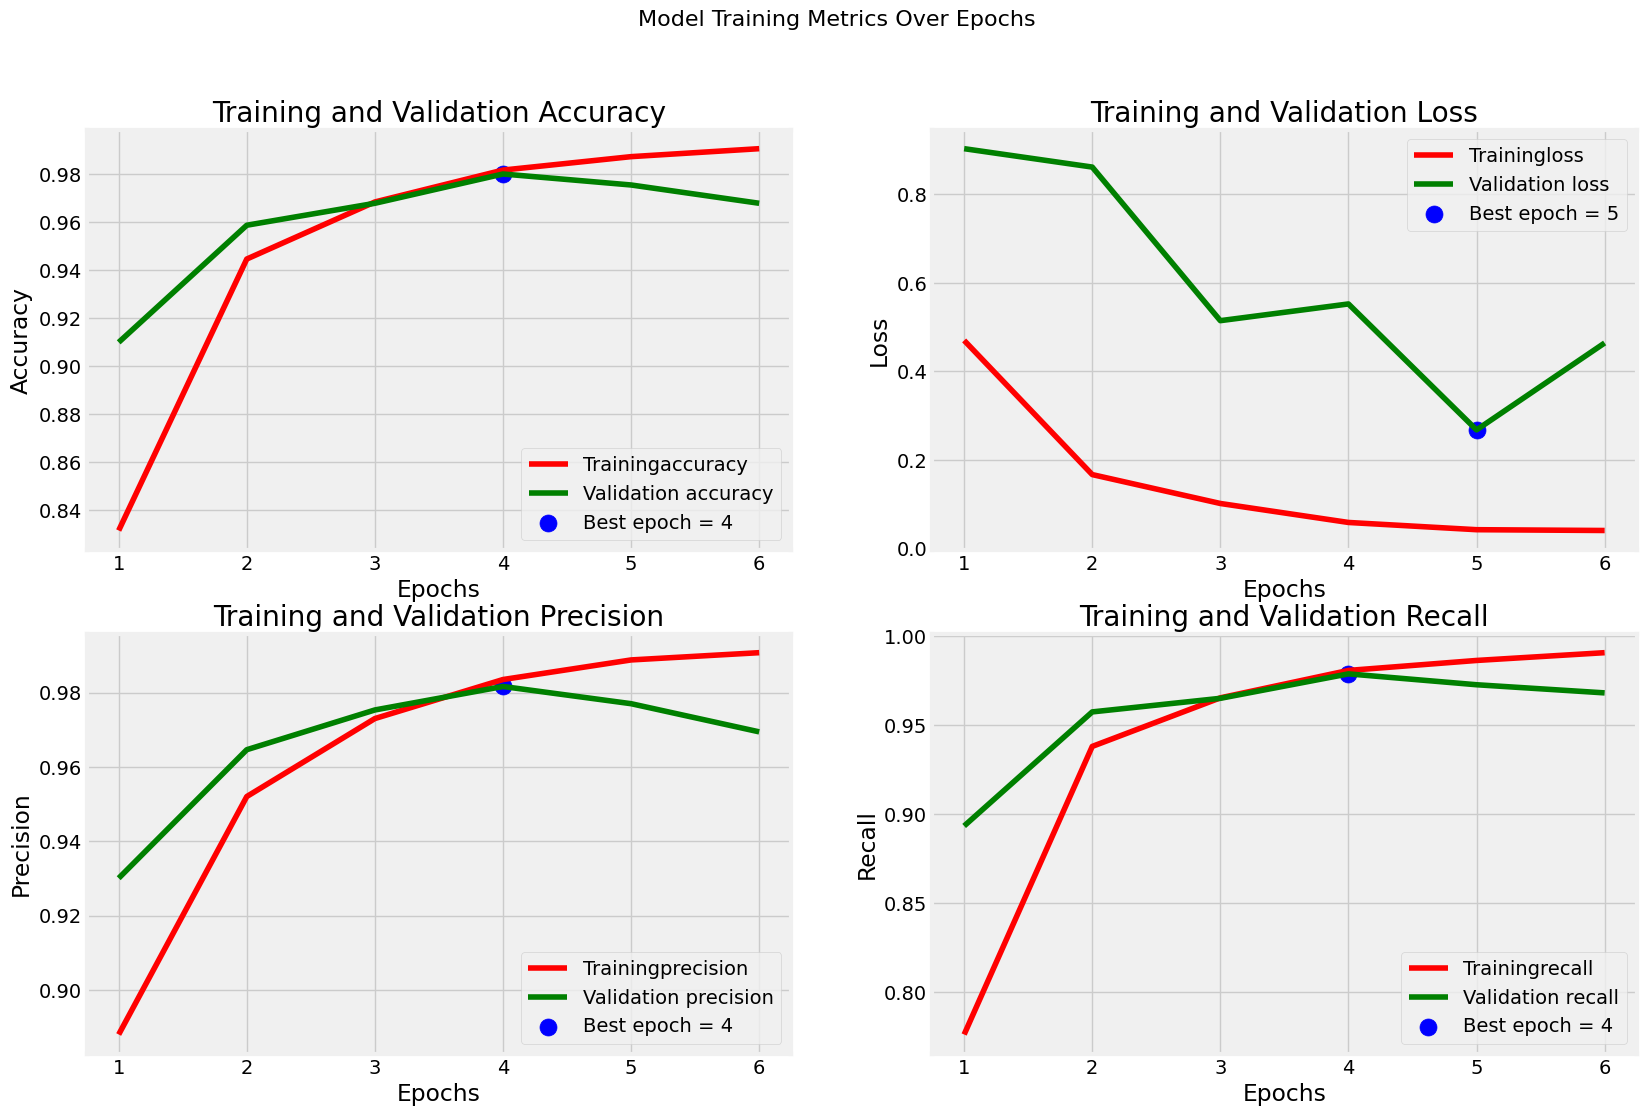

In [25]:
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m] )
  best_epochs[m] = idx + 1
  best_values[m] =val_metrics[m][idx]
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')
for i, metric in enumerate (metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics[metric]) + 1)
  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training{metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel (metric.title())
  plt.legend()
  plt.grid(True)
plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt. show()

### Model Evaluation

In [26]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score [1]*100: .2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score [1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

41/41 [==============================] - 9s 207ms/step - loss: 0.4662 - accuracy: 0.9710 - precision: 0.9710 - recall: 0.9695
Train Accuracy: 98.60%
Train Loss: 0.1395


Validation Accuracy:  96.49%
Validation Loss: 0.2918


Test Accuracy: 97.10%
Test Loss: 0.4662


41/41 [==============================] - 3s 49ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

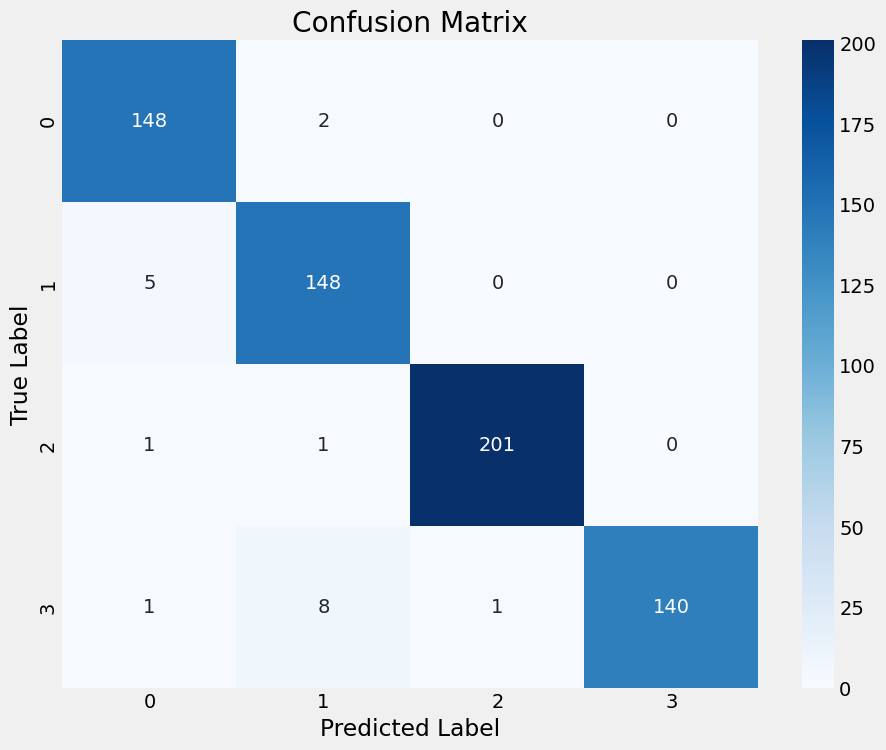

In [27]:
preds = model. predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = {
  0: 'glioma',
  1:'meningioma',
  2: 'no_tumor',
  3: 'pituitary'
}
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list (class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel ('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show

In [28]:
from PIL import Image

In [29]:
def predict(img_path: str) -> None:
    labels = list(class_dict.keys())
    plt.figure(figsize=(6, 8))
    img = Image.open(img_path)
    resized_img = img.resize((128, 128))
    img_array = np.asarray(resized_img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    predictions = model.predict(img_array)
    probabilities = list(predictions[0])
    predicted_class_idx = np.argmax(probabilities)
    print(predicted_class_idx)
    predicted_class = class_dict[predicted_class_idx]
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.title(f"Input MRI Image\nPredicted: {predicted_class}")
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probabilities)
    plt.xlabel ("Probability", fontsize=15)
    plt.title("Class Probabilities")
    ax = plt.gca()
    ax.bar_label (bars, fmt="%.2f")
    plt.tight_layout ()
    plt.show()
    print(f"Predicted tumor type: {predicted_class}")

1/1 [==============================] - 3s 3s/step
1


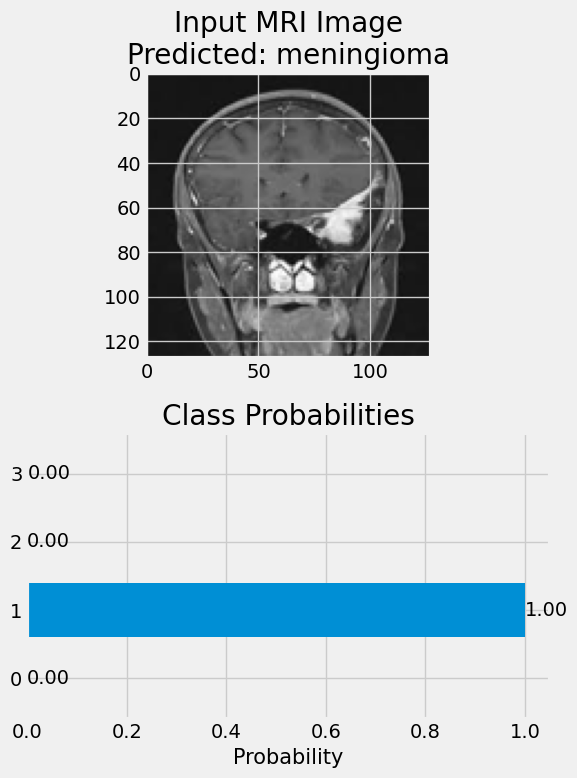

Predicted tumor type: meningioma


In [30]:
predict("./Testing/meningioma/Te-meTr_0003.jpg")

1/1 [==============================] - 0s 60ms/step
0


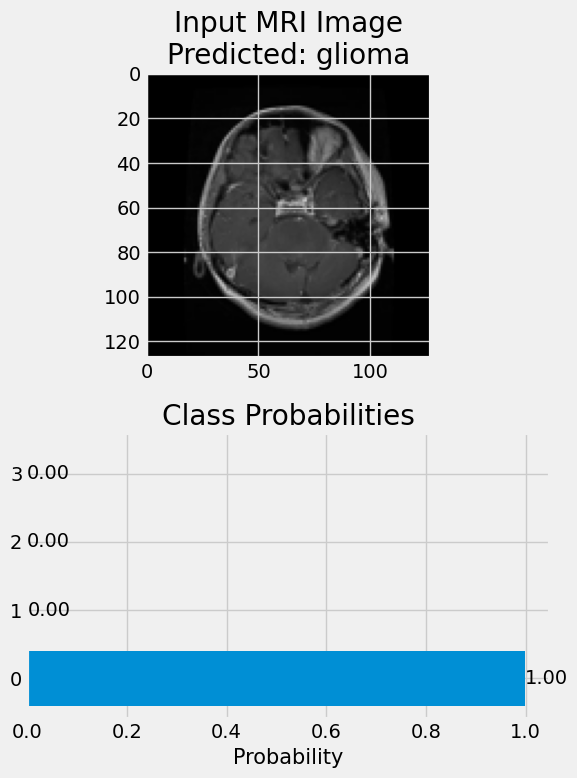

Predicted tumor type: glioma


In [31]:
predict("./Testing/glioma/Te-gl_0010.jpg")

In [60]:
model.save_weights("xception_model.weights.h5")

In [32]:
model.save("xception_model.h5")

In [33]:
model.save("xception_model")

INFO:tensorflow:Assets written to: xception_model\assets


INFO:tensorflow:Assets written to: xception_model\assets


### CNN Model

In [61]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [65]:
batch_size = 8

img_size = (128, 128)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = image_generator.flow_from_dataframe(tr_df, x_col = 'Class Path', y_col ='Class', batch_size=batch_size, target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df, x_col = 'Class Path', y_col ='Class', batch_size=batch_size, target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col = 'Class Path', y_col ='Class', batch_size=8, target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [66]:
cnn_model = Sequential()
# Convolutional layers
cnn_model.add(Conv2D (512, (3, 3), padding='same', input_shape=(128,128,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout (0.25))
cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout (0.25))
cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout (0.35))
cnn_model.add(Dense(4, activation='softmax')) # Output layer with 4 neurons for the 4 classes
# Compile the model
cnn_model.compile(Adamax( learning_rate = 0.001), loss='categorical_crossentropy', metrics= ['accuracy', Precision() ,Recall()])
# Display the model summary
cnn_model.summary ()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 512)     14336     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 512)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 256)       1179904   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 128)      

In [67]:
history = cnn_model.fit(tr_gen, epochs=8, validation_data=valid_gen)

Epoch 1/8
714/714 [==============================] - 77s 103ms/step - loss: 1.4062 - accuracy: 0.6910 - precision_2: 0.7760 - recall_2: 0.5833 - val_loss: 0.9435 - val_accuracy: 0.7008 - val_precision_2: 0.7314 - val_recall_2: 0.6443
Epoch 2/8
714/714 [==============================] - 67s 94ms/step - loss: 0.6793 - accuracy: 0.8160 - precision_2: 0.8355 - recall_2: 0.7897 - val_loss: 0.5951 - val_accuracy: 0.8183 - val_precision_2: 0.8421 - val_recall_2: 0.7817
Epoch 3/8
714/714 [==============================] - 68s 95ms/step - loss: 0.5307 - accuracy: 0.8559 - precision_2: 0.8696 - recall_2: 0.8395 - val_loss: 0.6341 - val_accuracy: 0.7939 - val_precision_2: 0.8122 - val_recall_2: 0.7725
Epoch 4/8
714/714 [==============================] - 68s 96ms/step - loss: 0.4457 - accuracy: 0.8824 - precision_2: 0.8926 - recall_2: 0.8715 - val_loss: 0.4897 - val_accuracy: 0.8412 - val_precision_2: 0.8520 - val_recall_2: 0.8351
Epoch 5/8
714/714 [==============================] - 69s 97ms/step 

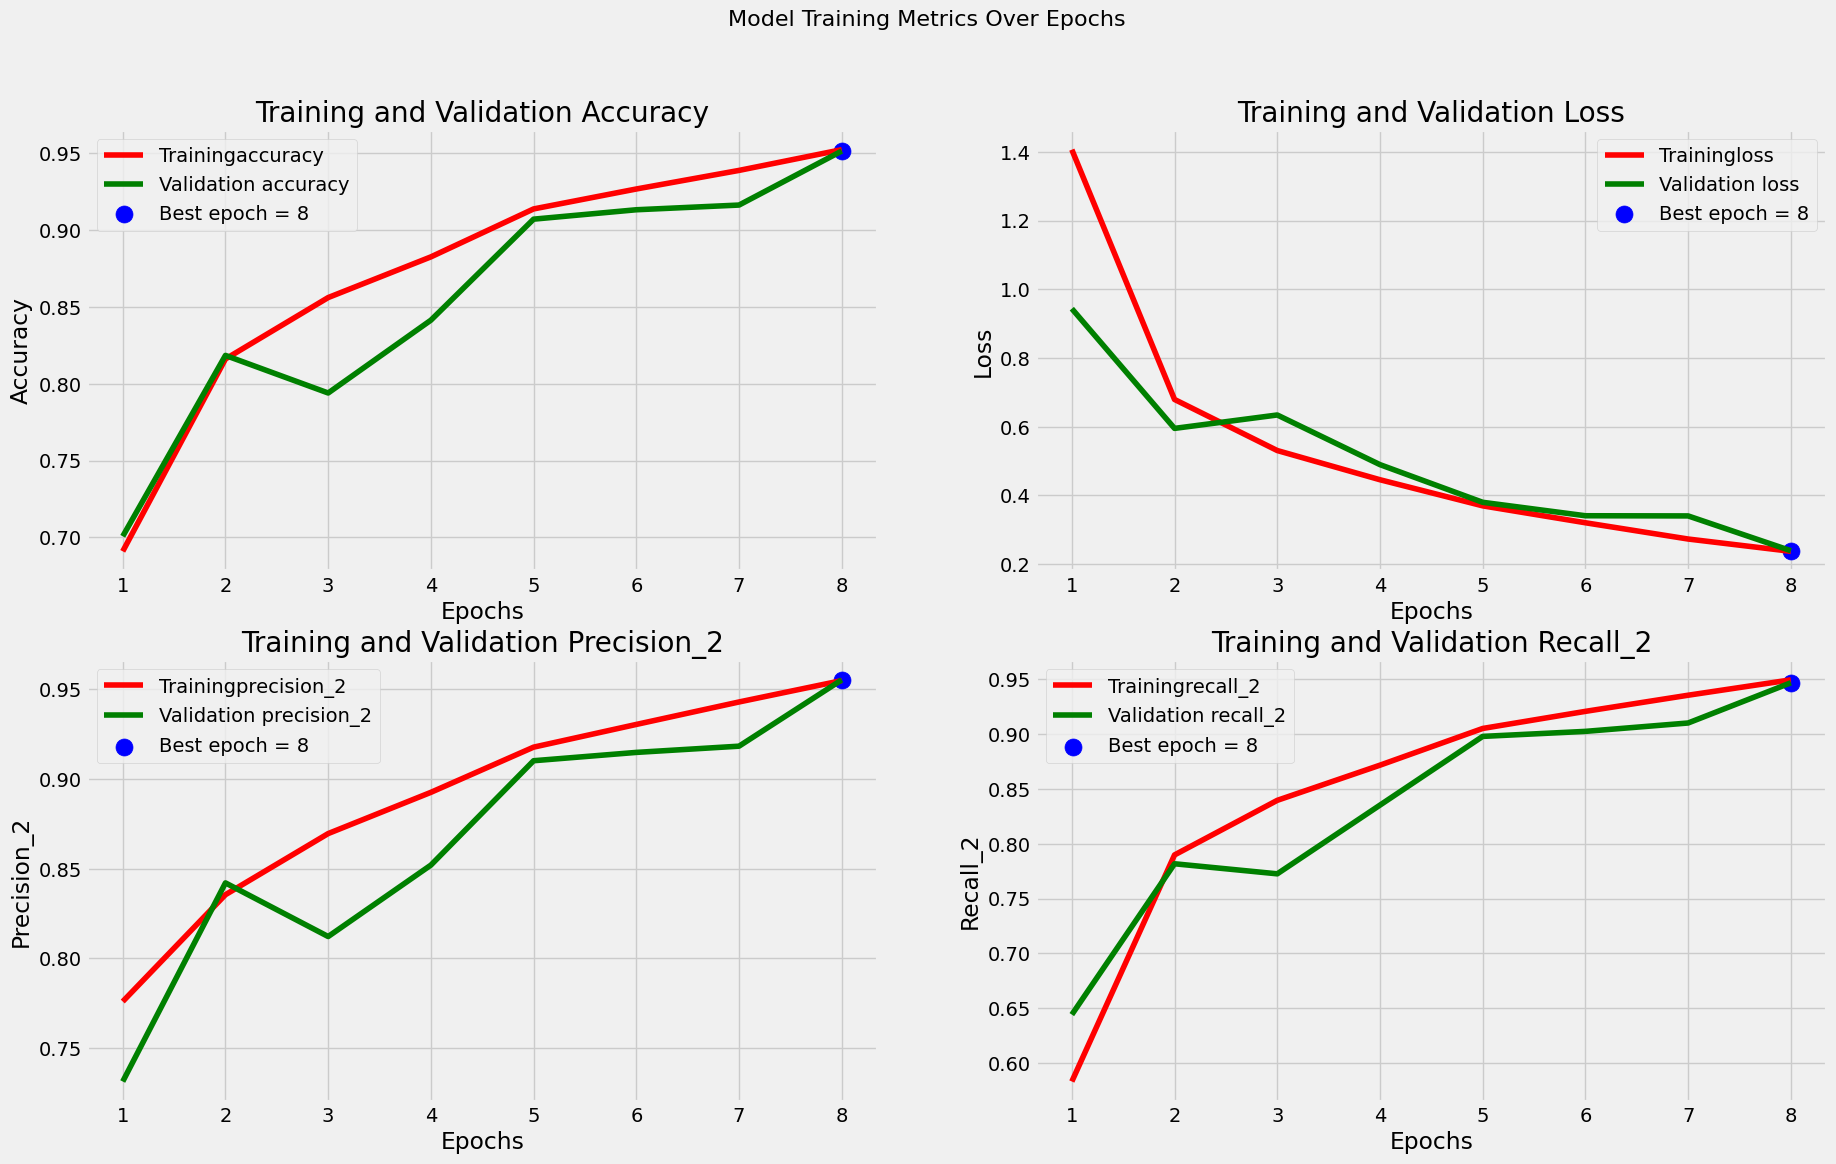

In [70]:
metrics = ['accuracy', 'loss', 'precision_2', 'recall_2']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m] )
  best_epochs[m] = idx + 1
  best_values[m] =val_metrics[m][idx]
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')
for i, metric in enumerate (metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics[metric]) + 1)
  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training{metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel (metric.title())
  plt.legend()
  plt.grid(True)
plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt. show()

In [71]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score [1]*100: .2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score [1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

82/82 [==============================] - 8s 103ms/step - loss: 0.2596 - accuracy: 0.9573 - precision_2: 0.9573 - recall_2: 0.9558
Train Accuracy: 98.35%
Train Loss: 0.1707


Validation Accuracy:  95.11%
Validation Loss: 0.2427


Test Accuracy: 95.73%
Test Loss: 0.2596


82/82 [==============================] - 3s 33ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

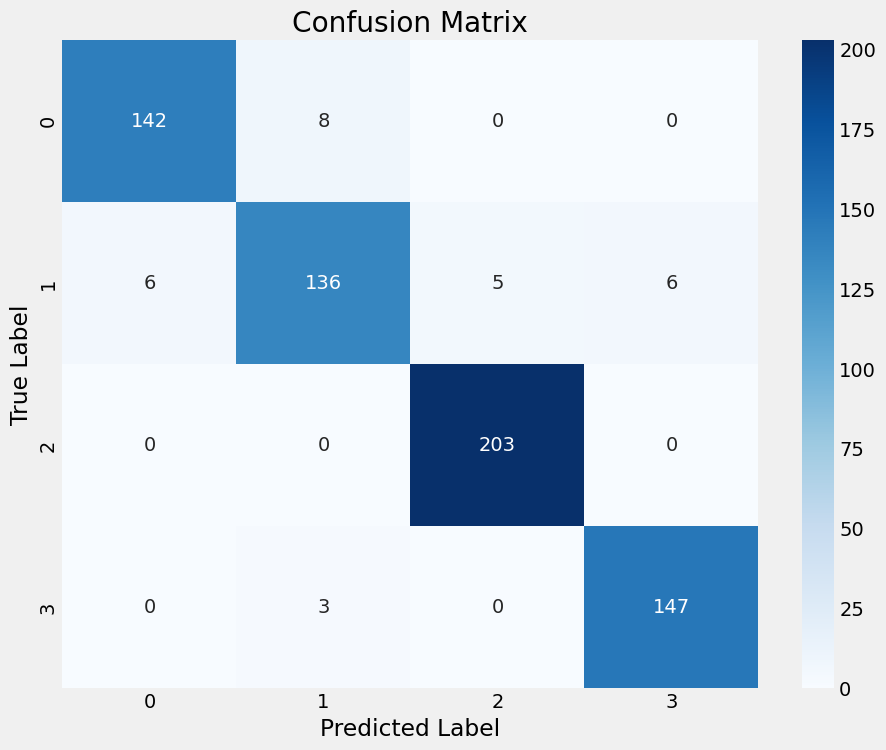

In [72]:
preds = cnn_model. predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict = {
  0: 'glioma',
  1:'meningioma',
  2: 'no_tumor',
  3: 'pituitary'
}
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list (class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel ('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show

In [73]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       150
           1       0.93      0.89      0.91       153
           2       0.98      1.00      0.99       203
           3       0.96      0.98      0.97       150

    accuracy                           0.96       656
   macro avg       0.96      0.95      0.95       656
weighted avg       0.96      0.96      0.96       656



In [74]:
cnn_model.save("cnn_model.h5")

In [101]:
import google.protobuf
print(google.protobuf.__version__)

3.19.6
